# NSGA-II

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

## Define zdt2 function

In [2]:
def zdt_2(x):
    f1 = float(x[0])
    sum1 = 0.0
    for i in range(x_num - 1):
        sum1 = sum1 + x[i + 1]
    g = float(1 + 9 * (sum1 / (x_num-1)))
    f2 = g * (1 - (f1 / g) ** 2)
    f = [f1,f2]
    return f

## Initializing population

In [3]:
def initialpop(N,x_num,f_num,x_max,x_min):
    chromo = np.zeros([N,x_num + f_num + 6])
    for i in range(N):
        for j in range(x_num):
            chromo[i,j] = x_min[0,j]+(x_max[0,j]-x_min[0,j])*random.random()
        chromo[i,x_num] = zdt_2(chromo[i,0:x_num])[0]
        chromo[i,x_num + 1] = zdt_2(chromo[i,0:x_num])[1]
    return chromo

## Non-domination sort

In [4]:
def nondominsort(chromo,N,x_num,f_num,x_max,x_min):
    f1 = chromo[:,x_num]
    f2 = chromo[:,x_num + 1]
    ps = [[] for i in range(0,len(f1))]#Record which individuals are dominated by individual i
    pn=[0 for i in range(0,len(f1))]#Record how many individuals i was dominated by
    F = [[]]
    rank = [0 for i in range(0, len(f1))]

    for  i in range(0,len(f1)):
        ps[i] = []
        pn[i] = 0

        for j in range (0,len(f1)):
            if (f1[i] < f1[j] and f2[i] < f2[j]) or (f1[i] <= f1[j] and f2[i] < f2[j]) or (f1[i] < f1[j] and f2[i] <= f2[j]):
                if j not in ps[i]:
                    ps[i].append(j)#Individual i dominates individual j, recording the individual
            elif (f1[j] < f1[i] and f2[j] < f2[i]) or (f1[j] <= f1[i] and f2[j] < f2[i]) or (f1[j] < f1[i] and f2[j] <= f2[i]) :                                                                                               
                pn[i] = pn[i] + 1# i is dominated by individual j, count +1
        
        if pn[i] == 0:#No individual can dominate i. Then i is a non-dominant individual
            rank[i] = 0
            if i not in F[0]:
                F[0].append(i)

    i = 0
    while (F[i] != []):
        temp = []
        for m in F[i] :
            for n in ps[m]:
                pn[n] = pn[n] -1
                if pn[n] == 0 :#Determine if it becomes a non-dominated solution?v
                    rank[n] = i + 1
                    if n not in temp:
                        temp.append(n)#Statistics pareto 'rank+1' level of the solution
        i = i + 1 #Then count the next level
        F.append(temp) #Record which individuals are included in the 'rank' hierarchy

    del F[len(F)-1]#Delete the last empty level
    
    chromo[:,x_num + f_num] = rank
    
    return F

## Crowding distance sort

In [5]:
def crowddissort(chromo,F,N,x_num,f_num,x_max,x_min):
    #chromo[:,x_num + f_num] = rank
    temp = np.array(sorted(chromo, key = lambda chromo:chromo[x_num + f_num]))#Populations sorted by pareto rank
    chromo_cd = []

    for f in range(len(F)):
        length = len(F[f])#How many individuals are included in this pareto rank layer
        y = temp[0:length,:]#Fetch all the individuals in this pareto rank layer. (temp is ranked)
        temp = np.delete(temp, np.s_[:length], axis=0)#Clear the pareto rank layer of individuals (to facilitate taking the next layer of individuals later)

        for i in range(f_num):
            y[:,x_num + f_num + i + 1] = [i for i in range(len(y))]#Index of the individual in its layer
            y_sort = np.array(sorted(y, key = lambda y:y[x_num + i]))#Population in the rank layer sorted by the i-th target value

            f_min = y_sort[0,x_num + i]#The minimum value of the i-th target in the layer
            f_max = y_sort[length - 1,x_num + i]#The maximum value of the i-th target in the layer
            y[int(y_sort[:,x_num + f_num + i + 1][0])][x_num + f_num + i + 3] = float("inf")#Set the individual interval with the smallest target value to infinite
            y[int(y_sort[:,x_num + f_num + i + 1][length - 1])][x_num + f_num + i + 3] = float("inf")#将The individual interval with the largest target value is set to infinite

            #Calculate the interval of other individuals
            j = 1
            while (j <= (length - 2)):
                pre_f = y_sort[j-1,x_num + i]#The i-th target value of the previous one of j
                next_f = y_sort[j + 1,x_num + i]#The i-th target value of the next j
                if (f_max - f_min == 0):
                     y[int(y_sort[:,x_num + f_num + i + 1][j])][x_num + f_num + i + 3] = float("inf")
                else:
                    y[int(y_sort[:,x_num + f_num + i + 1][j])][x_num + f_num + i + 3] = float((next_f-pre_f)/(f_max-f_min))
                j = j + 1


        #Calculating crowding
        y[:,x_num + f_num + 5] = y[:,x_num + f_num + 3] + y[:,x_num + f_num + 4]
        y = np.array(y)
        chromo_cd.append(y)

    chromo = np.array([x for y in chromo_cd for x in y])
    
    return chromo

## Tournament selection

In [6]:
def tournamentselect(chromo,F,N,x_num,f_num,x_max,x_min):
    pick = []#Record the selected individuals
    a=round(N/2)
    index = list(np.arange(0,100,1))

    for i in range(N):
        index_pick = random.sample(index,a)#k individuals were randomly selected for comparison
        rank_pick = chromo[index_pick,x_num + f_num]#Pareto hierarchy of the selected k individuals
        dis_pick = chromo[index_pick,x_num + f_num + 5]#The crowding of the selected k individuals
        idx_rank = np.argwhere(rank_pick == min(rank_pick))#Indexing of individuals at the smallest level
        idx_dis = np.argwhere(dis_pick[idx_rank] == max(dis_pick[idx_rank]))#Individual index of maximum congestion
        chose = random.sample(list(idx_dis[:,0]),1)#If you do a comparison or more than one, choose one at random
        idx = idx_rank[chose].ravel()#to the index of the selected individual in the parent
        pick.append(idx)#Record Index

    pick = list(np.array(pick).flatten())
    
    return pick

## Crossover

In [7]:
def crossover(chromo,F,pick,pc,yita1,N,x_num,f_num,x_max,x_min):
    temp = chromo[pick, 0:x_num]#Take out the selected individuals
    off_s = []#Storage of offspring individuals
    index = list(np.arange(0,100,1))

    for i in range(N):
        #Pick out two different individuals to cross
        pick_cros = random.sample(index , 2)
        while pick[pick_cros[0]] == pick[pick_cros[1]]:
            pick_cros = random.sample(index , 2)

        off_1 = chromo[pick_cros[0], :]
        off_2 = chromo[pick_cros[1], :]
        
        #Each dimension is crossed by the formula
        if random.random() < pc:
            for j in range(x_num):
                u = random.random()
                if u < 0.5:
                    gama = (2 * u)**(1 / (yita1 + 1))
                else:
                    gama = (1 / (2 * (1 - u)))**(1 / (yita1+1))

                off_1[j] = 0.5 * ((1 + gama) * off_1[j] + (1 - gama) * off_2[j])
                off_2[j] = 0.5 * ((1 - gama) * off_1[j] + (1 + gama) * off_2[j])
            
            #Modify if the boundary is exceeded
            off_1[0:x_num] = np.minimum(off_1[0:x_num], x_max.flatten())
            off_1[0:x_num] = np.maximum(off_1[0:x_num], x_min.flatten())
            off_2[0:x_num] = np.minimum(off_2[0:x_num], x_max.flatten())
            off_2[0:x_num] = np.maximum(off_2[0:x_num], x_min.flatten())

        off_s.append(off_1)
        off_s.append(off_2)

    off_s = np.array(off_s)
    indexx = list(np.arange(0,200,1)) 
    pick = random.sample(index,N)#N randomly selected from 2*N
    chromo = off_s[pick,:]
    
    return chromo

## Mutation

In [8]:
def mutation(chromo,F,pick,pm,yita2,N,x_num,f_num,x_max,x_min):
    for i in range(N):
        if random.random() < pm:
            # Each dimension has to be mutated by the formula
            for  j in range(x_num):
                u = random.random()
                if u < 0.5:
                    delta = (2 * u)**(1 / (yita2+1)) - 1
                else:
                    delta = 1 - (2 * (1 - u))**(1 / (yita2+1))

                chromo[i,j] = chromo[i,j] + delta

        chromo[i,0:x_num] = np.minimum(chromo[i,0:x_num], x_max.flatten())
        chromo[i,0:x_num] = np.maximum(chromo[i,0:x_num], x_min.flatten())
        chromo[i,x_num:x_num+2] = zdt_2(chromo[i,0:x_num])#Calculate the value of each objective function    
    
    return chromo

## Elitism

In [9]:
def elitism(chromo_co,N,x_num,f_num,x_max,x_min):
    chromo_co = chromo_cd_co
    chromo = []
    chromo_sort = np.array(sorted(chromo_co, key = lambda chromo_co:chromo_co[x_num + f_num]))#The merged chromo is sorted by pareto rank
    rank = 0

    while True:
        # Take pareto rank whole layer
        index = np.argwhere(chromo_co[:,x_num + f_num] == rank).flatten()
        temp = list(chromo_sort[index,:])
        temp = np.array(sorted(temp, key = lambda temp:temp[x_num + f_num + 5],reverse=True))
        chromo.extend(temp)
        if np.shape(chromo)[0] >= N:
            break
        rank = rank + 1

    chromo = np.array(chromo)[0:N,:]
    
    return chromo

## Main

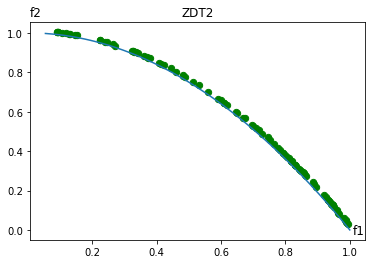

In [10]:
N = 100 #Population size
x_num = 30 #Solve for the dimension
f_num = 2 #Number of objectives
x_min = np.zeros((1,x_num))#Minimum value of decision variables
x_max = np.ones((1,x_num))#Maximum value of decision variables
pc = 0.9 #Crossover probability
pm = 1 / x_num #Mutation probability
yita1 = 20
yita2 = 20
iteration = 3000 #Maximum number of iterations

# Initializing the population
chromo_pop = initialpop(N,x_num,f_num,x_max,x_min)
F = nondominsort(chromo_pop,N,x_num,f_num,x_max,x_min) #Non-dominated ranking, number of populations is N
chromo = crowddissort(chromo_pop,F,N,x_num,f_num,x_max,x_min)#Calculate the degree of crowding with the number of populations as N

#Start Iteration
for i in range(iteration):
    parentchromo = chromo #Defining the parent population
    pick = tournamentselect(parentchromo,F,N,x_num,f_num,x_max,x_min)#Select
    chromo_cros = crossover(parentchromo,F,pick,pc,yita1,N,x_num,f_num,x_max,x_min)#Crossover
    chromo_off = mutation(chromo_cros,F,pick,pm,yita2,N,x_num,f_num,x_max,x_min)#Variation
    
    #Population merging
    chromo_co = np.concatenate((parentchromo,chromo_off),axis=0)#The number of populations is 2*NP
    F_co = nondominsort(chromo_co,N,x_num,f_num,x_max,x_min)##Non-dominated ranking, number of populations is 2*N
    chromo_cd_co = crowddissort(chromo_co,F,N,x_num,f_num,x_max,x_min)#Calculate the degree of crowding with the number of populations as 2*N
    chromo = elitism(chromo_cd_co,N,x_num,f_num,x_max,x_min)
    
    i = i + 1

#Elite Retention
chromo = np.array(sorted(chromo,key=lambda chromo:chromo[x_num]))

#Import test data for comparison against optimization results.
testdata = pd.read_csv('D://asu/IEE 598 Bio/mini project 2/ZDT2.csv')
f1_test = testdata.iloc[:,0]
f2_test = testdata.iloc[:,1]

#Visualization
plt.title("f1",y=0,loc='right')
plt.title("f2",y=1,loc='left')
plt.title("ZDT2")
plt.scatter(chromo[:,x_num],chromo[:,x_num + 1],marker='o',color='green',s=40)
plt.plot(f1_test,f2_test)
plt.show()

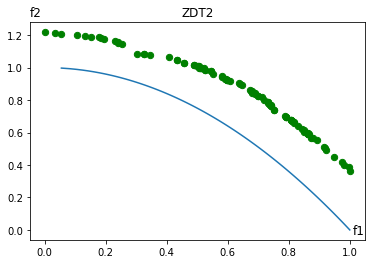

In [11]:
iteration = 500

# Initializing the population
chromo_pop = initialpop(N,x_num,f_num,x_max,x_min)
F = nondominsort(chromo_pop,N,x_num,f_num,x_max,x_min) #Non-dominated ranking, number of populations is N
chromo = crowddissort(chromo_pop,F,N,x_num,f_num,x_max,x_min)#Calculate the degree of crowding with the number of populations as N

#Start Iteration
for i in range(iteration):
    parentchromo = chromo #Defining the parent population
    pick = tournamentselect(parentchromo,F,N,x_num,f_num,x_max,x_min)#Select
    chromo_cros = crossover(parentchromo,F,pick,pc,yita1,N,x_num,f_num,x_max,x_min)#Crossover
    chromo_off = mutation(chromo_cros,F,pick,pm,yita2,N,x_num,f_num,x_max,x_min)#Variation
    
    #Population merging
    chromo_co = np.concatenate((parentchromo,chromo_off),axis=0)#The number of populations is 2*NP
    F_co = nondominsort(chromo_co,N,x_num,f_num,x_max,x_min)##Non-dominated ranking, number of populations is 2*N
    chromo_cd_co = crowddissort(chromo_co,F,N,x_num,f_num,x_max,x_min)#Calculate the degree of crowding with the number of populations as 2*N
    chromo = elitism(chromo_cd_co,N,x_num,f_num,x_max,x_min)
    
    i = i + 1

#Elite Retention
chromo = np.array(sorted(chromo,key=lambda chromo:chromo[x_num]))

#Import test data for comparison against optimization results.
testdata = pd.read_csv('D://asu/IEE 598 Bio/mini project 2/ZDT2.csv')
f1_test = testdata.iloc[:,0]
f2_test = testdata.iloc[:,1]

#Visualization
plt.title("f1",y=0,loc='right')
plt.title("f2",y=1,loc='left')
plt.title("ZDT2")
plt.scatter(chromo[:,x_num],chromo[:,x_num + 1],marker='o',color='green',s=40)
plt.plot(f1_test,f2_test)
plt.show()